(plotmon-tutorial)=
# Tutorial 5. Plot monitor

```{seealso}
The complete source code of this tutorial can be found in

{nb-download}`Tutorial 5. Plot monitor.ipynb`
```

In this tutorial we dive into the capabilities of the plot monitor.
We will create a fictional device and showcase how the plot monitor can be used. Enjoy!

In [1]:
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
from qcodes import Instrument, ManualParameter

from quantify_core.data.handling import (
    get_tuids_containing,
    set_datadir,
    default_datadir,
)
from quantify_core.measurement import MeasurementControl
from quantify_core.visualization.pyqt_plotmon import PlotMonitor_pyqt

rng = np.random.default_rng(seed=555555)  # random number generator

# Display any variable or statement on its own line
InteractiveShell.ast_node_interactivity = "all"

Before instantiating any instruments or starting a measurement we change the
directory in which the experiments are saved using the
{meth}`~quantify_core.data.handling.set_datadir`
\[{meth}`~quantify_core.data.handling.get_datadir`\] functions.

----------------------------------------------------------------------------------------

⚠️ **Warning!**

We recommend always setting the directory at the start of the python kernel and stick
to a single common data directory for all notebooks/experiments within your
measurement setup/PC.

The cell below sets a default data directory (`~/quantify-data` on Linux/macOS or
`$env:USERPROFILE\\quantify-data` on Windows) for tutorial purposes. Change it to your
desired data directory. The utilities to find/search/extract data only work if
all the experiment containers are located within the same directory.

----------------------------------------------------------------------------------------

In [2]:
set_datadir(default_datadir())

Data will be saved in:
/root/quantify-data


## QCoDeS drivers for our instruments

In [3]:
class Device(Instrument):
    """A dummy instrument."""

    def __init__(self, name: str):
        super().__init__(name=name)

        self.add_parameter(name="amp_0", unit="A", parameter_class=ManualParameter)
        self.add_parameter(name="amp_1", unit="A", parameter_class=ManualParameter)
        self.add_parameter(name="offset", unit="A", parameter_class=ManualParameter)

        self.add_parameter(
            name="adc", label="ADC input", unit="V", get_cmd=self._get_dac_value
        )

    def _get_dac_value(self):
        s1 = np.exp(-3 * self.amp_0()) * np.sin(self.amp_0() * 2 * np.pi * 3)
        s2 = np.cos(self.amp_1() * 2 * np.pi * 2)
        return s1 + s2 + rng.uniform(0, 0.2) + self.offset()

## Instantiate the instruments

In [4]:
meas_ctrl = MeasurementControl("meas_ctrl")
plotmon = PlotMonitor_pyqt("PlotMonitor")
meas_ctrl.instr_plotmon(plotmon.name)
device = Device("Device")

## Overview

There are 3 parameters in the {class}`.PlotMonitor_pyqt` that control the datasets being displayed.

Two main parameters determine the datasets being displayed: *tuids* and *tuids_extra*.

In [5]:
plotmon.tuids()
plotmon.tuids_extra()

[]

[]

The interface is the same for both. The parameters accept a list of tuids or an empty list to reset.

In [6]:
### Example of loading datasets onto the plot
#plotmon.tuids(["20201124-184709-137-8a5112", "20201124-184716-237-918bee"])
#plotmon.tuids_extra(["20201124-184722-988-0463d4", "20201124-184729-618-85970f"])

The difference is that the {class}`.MeasurementControl` uses `tuids` and overrides them when running measurements.

```{note}
All the datasets must have matching data variables (settables and gettables).
```

The third relevant parameter is the `tuids_max_num`. It accepts an integer that determines the maximum number of datasets that will be stored in `tuids` when the {class}`.MeasurementControl` is running.

In [7]:
plotmon.tuids_max_num()

3

```{note}
This parameter has no effect when setting the `tuids` manually.
```

## Usage examples

In [8]:
# set initial values to emulate the instrument state
device.amp_0(0.0)
device.amp_1(0.0)
device.offset(0.0)

n_pnts = 50

meas_ctrl.settables(device.amp_0)
meas_ctrl.setpoints(np.linspace(0, 1, n_pnts))
meas_ctrl.gettables(device.adc)
dset = meas_ctrl.run("ADC scan")

Starting iterative measurement...


Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

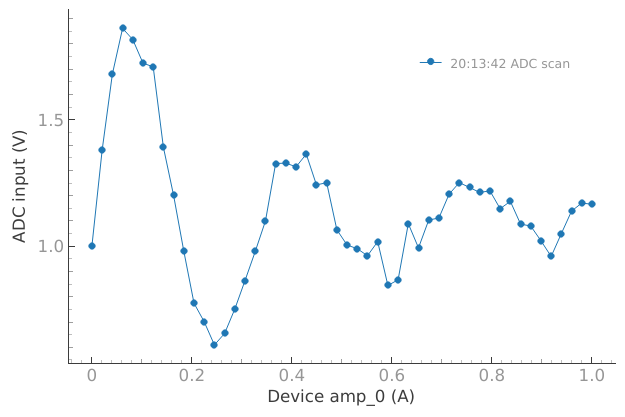

In [9]:
plotmon.main_QtPlot

In [10]:
n_pnts = 20

meas_ctrl.settables(device.amp_0)
meas_ctrl.setpoints(np.linspace(0, 1, n_pnts))
meas_ctrl.gettables(device.adc)
dset = meas_ctrl.run("ADC scan")

Starting iterative measurement...


Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

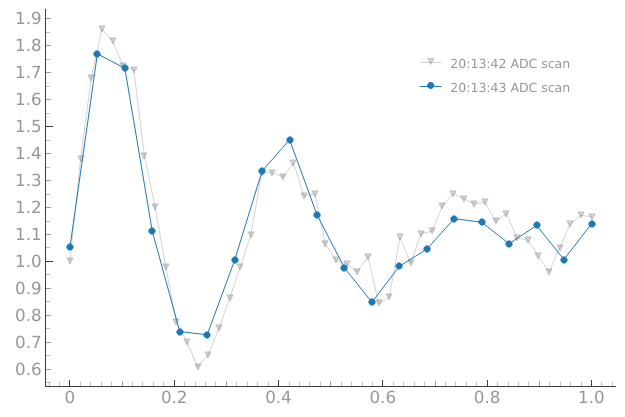

In [11]:
plotmon.main_QtPlot

In [12]:
n_pnts = 30

meas_ctrl.settables(device.amp_0)
meas_ctrl.setpoints(np.linspace(0, 1, n_pnts))
meas_ctrl.gettables(device.adc)
dset = meas_ctrl.run("ADC scan")

Starting iterative measurement...


Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

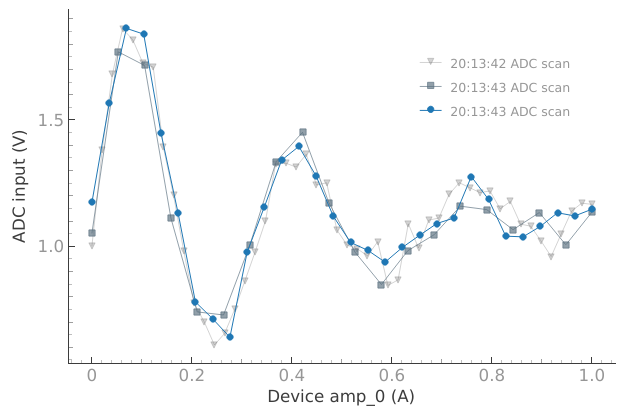

In [13]:
plotmon.main_QtPlot

Now the oldest dataset will vanish from the plot:

In [14]:
# Now the oldest dataset will vanish from the plot

n_pnts = 40

meas_ctrl.settables(device.amp_0)
meas_ctrl.setpoints(np.linspace(0, 1, n_pnts))
meas_ctrl.gettables(device.adc)
dset = meas_ctrl.run("ADC scan")

Starting iterative measurement...


Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

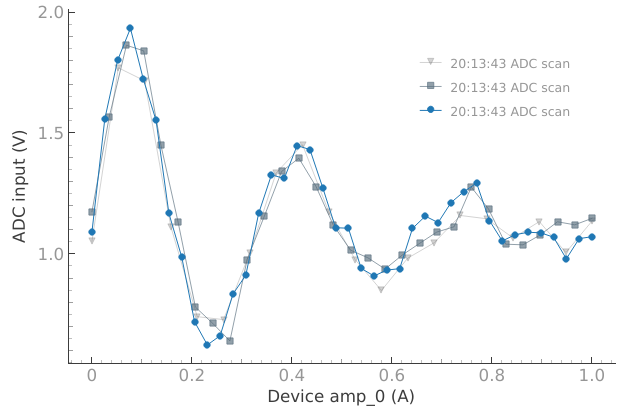

In [15]:
plotmon.main_QtPlot

We can accumulate more datasets on the plot if we want to:

In [16]:
# We can accumulate more datasets on the plot if we want to
plotmon.tuids_max_num(4)
n_pnts = 40

meas_ctrl.settables(device.amp_0)
meas_ctrl.setpoints(np.linspace(0, 1, n_pnts))
meas_ctrl.gettables(device.adc)
dset = meas_ctrl.run("ADC scan")

Starting iterative measurement...


Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

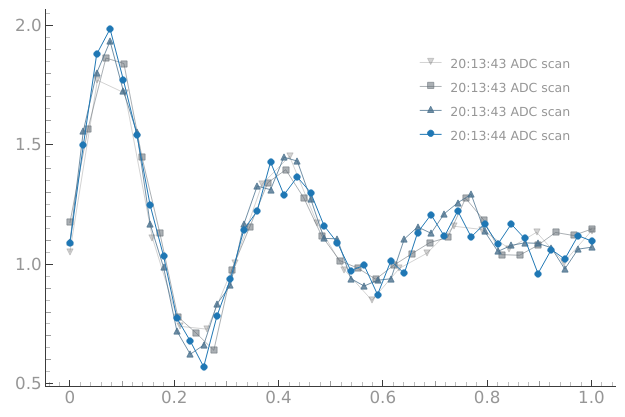

In [17]:
plotmon.main_QtPlot

Or we can disable the accumulation and plot a single dataset:

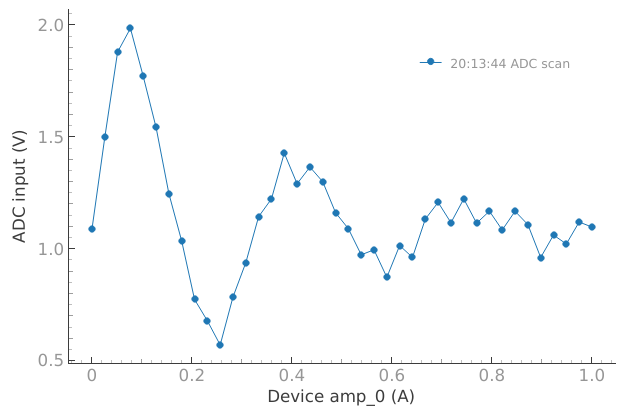

In [18]:
# Or we can disable the accumulation and plot a single dataset
plotmon.tuids_max_num(1)

plotmon.main_QtPlot

This can also be reset:

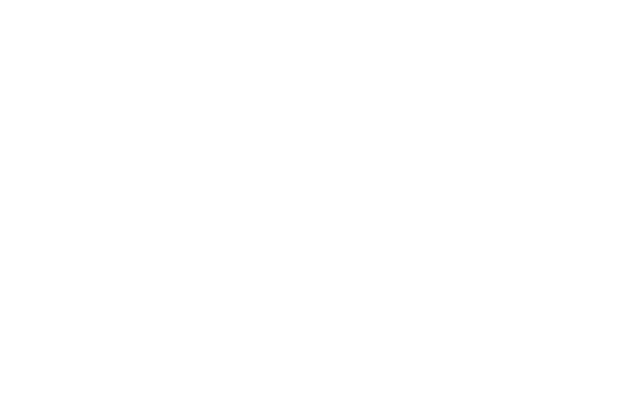

In [19]:
# This can also be reset with
plotmon.tuids([])

plotmon.main_QtPlot  # The plotting window will vanish, it is supposed to

For now, we will allow two datasets on the plot monitor.

In [20]:
# For now we will allow two datasets on the plot monitor
plotmon.tuids_max_num(2)

Now let's imagine that something strange is happening with our setup...

In [21]:
# Now let's imagine that something strange is happening with our setup
device.offset(1.5)

n_pnts = 40
meas_ctrl.settables(device.amp_0)
meas_ctrl.setpoints(np.linspace(0, 1, n_pnts))
meas_ctrl.gettables(device.adc)
dset = meas_ctrl.run("ADC scan problem")

Starting iterative measurement...


Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

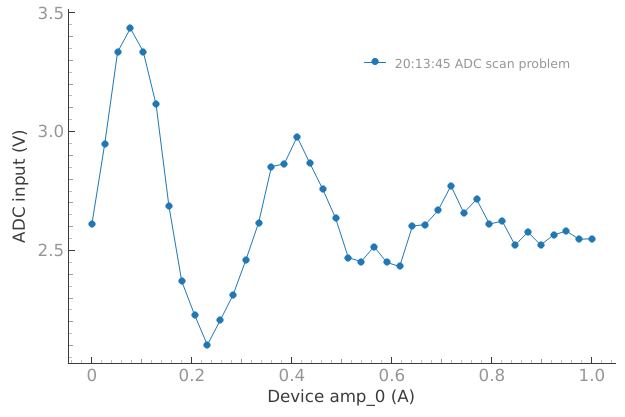

In [22]:
plotmon.main_QtPlot

We would like to compare if the current behavior matches for example what we got a few minutes ago:

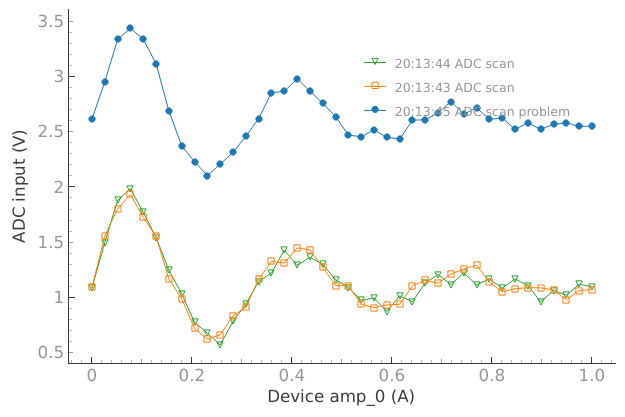

In [23]:
# We would like to compare if the current behavior matches for example
# what we got a few minutes ago

reference_tuids = sorted(get_tuids_containing("ADC"))[-3:-1]

plotmon.tuids_extra(reference_tuids)
plotmon.main_QtPlot

OK... that cable was not connected in the right place...

In [24]:
device.offset(0.0)  # OK... that cable was not connected in the right place...

# Now let's run again our experiments while we compare it to the previous one in realtime

n_pnts = 30
meas_ctrl.settables(device.amp_0)
meas_ctrl.setpoints(np.linspace(0, 1, n_pnts))
meas_ctrl.gettables(device.adc)
dset = meas_ctrl.run("ADC scan")

n_pnts = 40
meas_ctrl.settables(device.amp_0)
meas_ctrl.setpoints(np.linspace(0, 1, n_pnts))
meas_ctrl.gettables(device.adc)
dset = meas_ctrl.run("ADC scan")

Starting iterative measurement...


Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

Starting iterative measurement...


Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

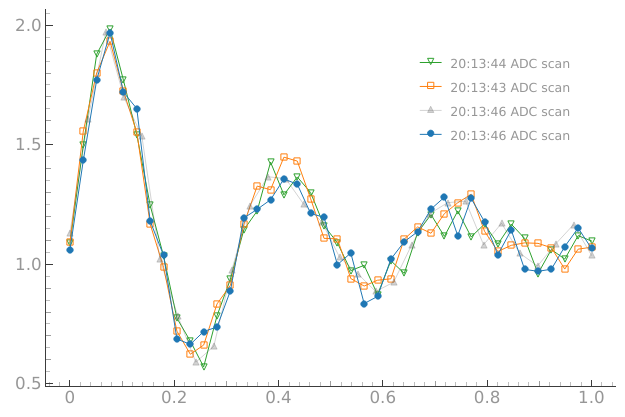

In [25]:
plotmon.main_QtPlot

We do not need the reference datasets anymore

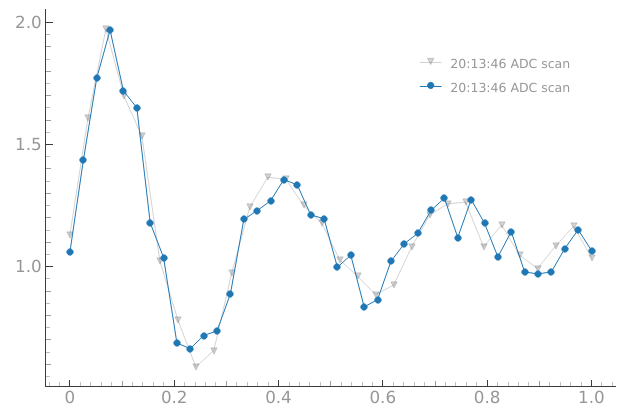

In [26]:
# We do not need the reference datasets anymore
plotmon.tuids_extra([])
plotmon.main_QtPlot

['20250320-201345-502-b5ea71']

Starting iterative measurement...


Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

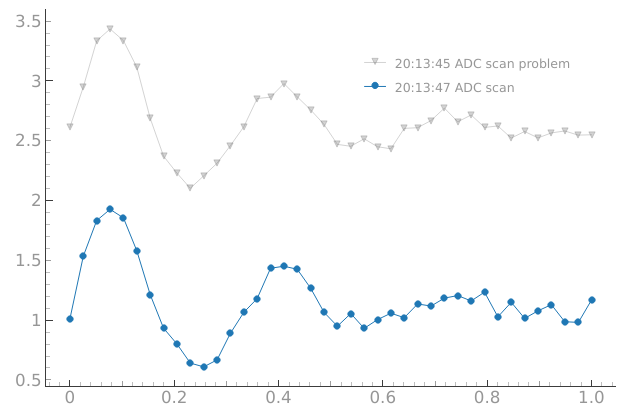

In [27]:
# Note: both plotmon.tuids_extra and plotmon.tuids can be used
# but keep in mind that meas_ctrl also uses the plotmon.tuids

tuids = get_tuids_containing("problem")[0:1]
tuids
plotmon.tuids(tuids)

n_pnts = 40
meas_ctrl.settables(device.amp_0)
meas_ctrl.setpoints(np.linspace(0, 1, n_pnts))
meas_ctrl.gettables(device.adc)
dset = meas_ctrl.run("ADC scan")

plotmon.main_QtPlot

When we have 2D plots only the first dataset from `plotmon.tuids` or `plotmon.tuids_extra` will be plotted in the secondary window, in that order of priority.

In [28]:
# When we have 2D plots only the first dataset from plotmon.tuids or
# plotmon.tuids_extra, in that order of priority, will be plotted in the
# secondary window

meas_ctrl.settables([device.amp_0, device.amp_1])
meas_ctrl.setpoints_grid([np.linspace(0, 1, 20), np.linspace(0, 0.5, 15)])
meas_ctrl.gettables(device.adc)
dset = meas_ctrl.run("ADC scan 2D")
reference_tuid_2D = dset.attrs["tuid"]

Starting iterative measurement...


Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

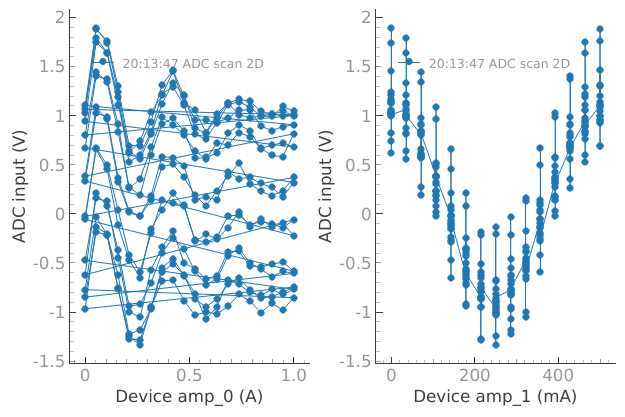

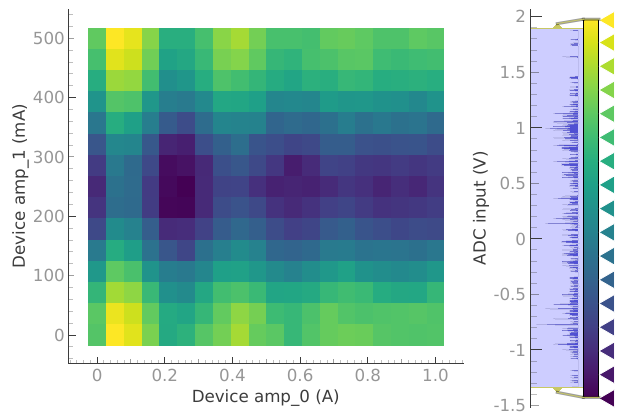

In [29]:
plotmon.main_QtPlot
plotmon.secondary_QtPlot

```{note}
The secondary window displays the last dataset with a 2D structure, and it remains persistent until replaced by a new dataset with a 2D structure.

Mind that the data on the secondary window does not always display data corresponding to the same dataset as the main window.
```

We still have the persistence of the previous dataset on the main window:

In [30]:
meas_ctrl.settables([device.amp_0, device.amp_1])
meas_ctrl.setpoints_grid([np.linspace(0, 1, 20), np.linspace(0, 0.5, 15)])
meas_ctrl.gettables(device.adc)
dset = meas_ctrl.run("ADC scan 2D")

Starting iterative measurement...


Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

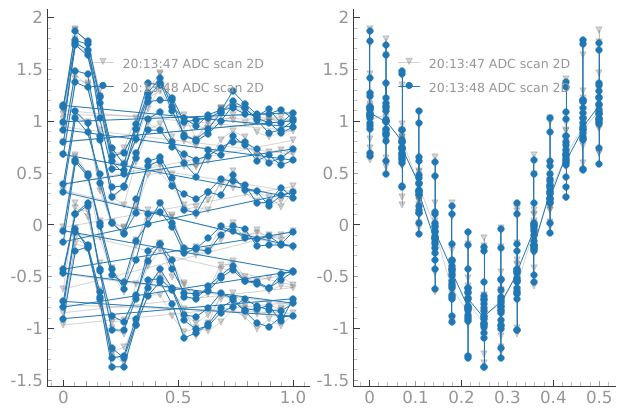

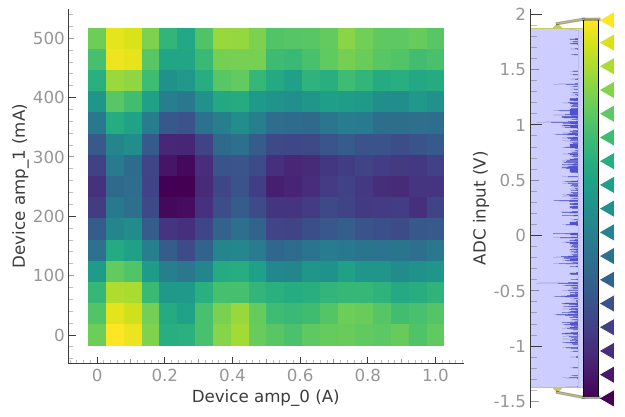

In [31]:
plotmon.main_QtPlot
plotmon.secondary_QtPlot

We can still have a permanent dataset as a reference in the main window:

In [32]:
device.offset(2.03)
plotmon.tuids_extra([reference_tuid_2D])

meas_ctrl.settables([device.amp_0, device.amp_1])
meas_ctrl.setpoints_grid([np.linspace(0, 1, 20), np.linspace(0, 0.5, 15)])
meas_ctrl.gettables(device.adc)
dset = meas_ctrl.run("ADC scan 2D")

Starting iterative measurement...


Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

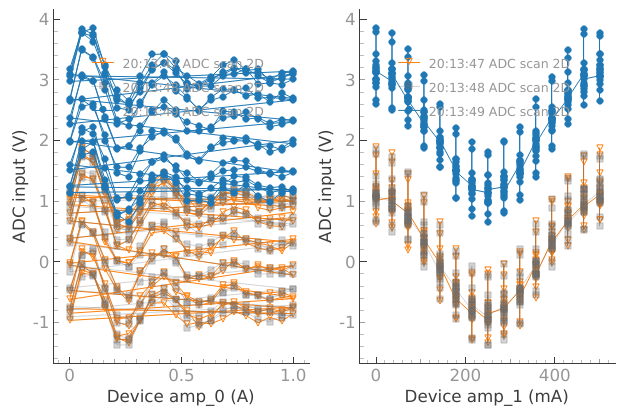

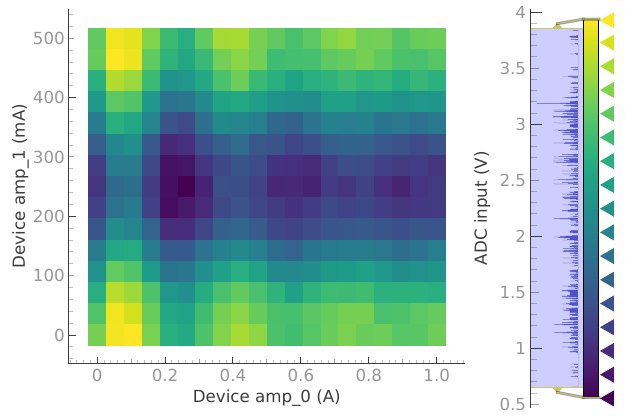

In [33]:
plotmon.main_QtPlot
plotmon.secondary_QtPlot

But if we want to see the 2D plot we need to reset `plotmon.tuids`.

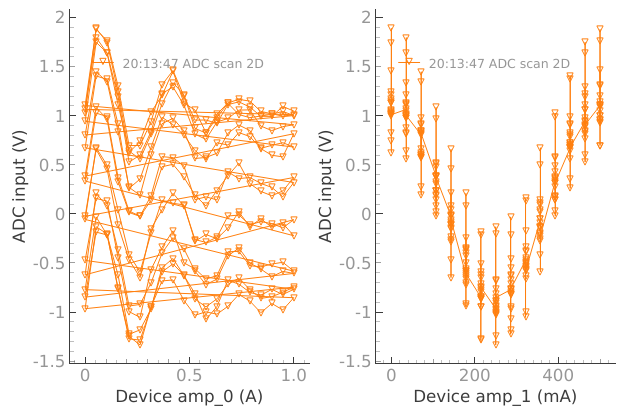

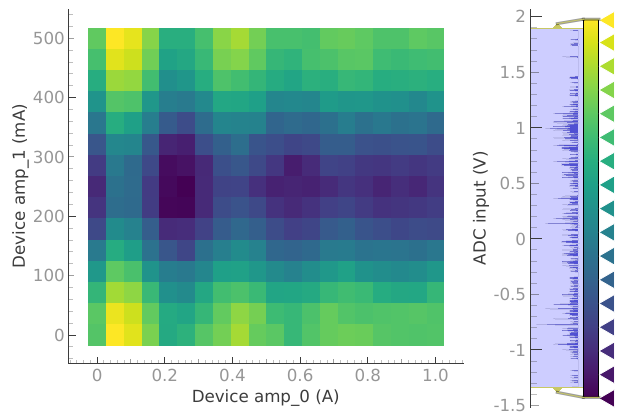

In [34]:
plotmon.tuids([])
plotmon.tuids_extra([reference_tuid_2D])
plotmon.main_QtPlot
plotmon.secondary_QtPlot

In [35]:
plotmon.tuids()

[]

Now your life will never be the same again ;)